<a href="https://colab.research.google.com/github/mantasviaz/Gmail-API-contacts/blob/main/docs/MoralMapFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import pandas as pd
import geopandas as gpd
import plotly.express as px
from shapely.geometry import Point
import numpy as np
from IPython.display import display, HTML


# Read the JSON data for users
with open('/content/drive/My Drive/NETS Data/users-2.json', 'r') as f:
    users_data = json.load(f)

# Read the JSON data for dilemmas
with open('/content/drive/My Drive/NETS Data/dilemmas.json', 'r') as f:
    dilemmas_data = json.load(f)

# Create a dictionary to map dilemma IDs to questions and issues
dilemma_dict = {dilemma["_id"]["$oid"]: (dilemma["question"], dilemma["issue"]) for dilemma in dilemmas_data}

# Prepare the data to be put into a DataFrame
users_list = []

for user in users_data:
    user_info = {
        "_id": user["_id"]["$oid"],
        "age": user.get("age"),
        "gender": user.get("gender"),
        "country": user.get("country"),
        "state": user.get("state"),
        "locationType": user.get("locationType"),
        "education": user.get("education"),
        "employmentStatus": user.get("employmentStatus"),
        "religion": user.get("religion"),
        "passedAttentionCheck": user.get("passedAttentionCheck"),
    }

    # Add each response with the corresponding issue as a separate column in the user_info dictionary
    for response in user["responses"]:
        dilemma_id = response["dilemmaId"]["$oid"]
        question, issue = dilemma_dict.get(dilemma_id, ("Unknown Question", None))
        if issue is not None:
            response_value = response.get("response")
            # Handle special case for 'Abortion'
            if issue.lower() == 'abortion':
                if response_value == 'Legal in all cases':
                    response_value = 'Yes'
                elif response_value == 'With restrictions':
                    response_value = 'Unsure'
                elif response_value == 'Illegal':
                    response_value = 'No'
            user_info[issue] = response_value

    users_list.append(user_info)

# Create the DataFrame
users_df = pd.DataFrame(users_list)

# Filter out rows without country filled in or empty strings
users_df = users_df[users_df["country"].notna() & (users_df["country"] != "")]

# Remove students not from the US
users_df = users_df[users_df["country"].str.lower() == "united states"]

# Remove rows where passedAttentionCheck is False
users_df = users_df[users_df["passedAttentionCheck"] != False]

# Load US states shapefile using GeoPandas
us_map = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
us_map = us_map[~us_map["name"].isin(["Alaska", "Hawaii", "Puerto Rico"])]  # Remove noncontiguous states

# Prepare data for plotting heat maps
for dilemma_id, (question, issue_name) in dilemma_dict.items():
    if issue_name in users_df.columns:
        # Filter responses for the issue
        issue_df = users_df[["state", issue_name]].dropna()
        issue_df = issue_df[issue_df[issue_name].isin(["Yes", "No", "Unsure"])]

        # Create GeoDataFrame for Yes, No, and Unsure responses
        yes_counts = issue_df[issue_df[issue_name] == "Yes"].groupby("state").size()
        no_counts = issue_df[issue_df[issue_name] == "No"].groupby("state").size()
        unsure_counts = issue_df[issue_df[issue_name] == "Unsure"].groupby("state").size() * 0.5  # Assign a weight of 0.5 for 'Unsure'

        # Calculate net response score (Yes - No + Unsure * 0.5) for gradient representation
        net_counts = yes_counts.subtract(no_counts, fill_value=0).add(unsure_counts, fill_value=0)

        # Calculate net response score (Yes - No) for gradient representation
        net_counts = yes_counts.subtract(no_counts, fill_value=0)

        # Add net response score to GeoDataFrame
        us_map["Net"] = us_map["name"].map(net_counts)

        # Set states without data to 0 (gray color)
        us_map["Net"] = us_map["Net"].fillna(0)

        # Plotting net responses on the map using Plotly
        fig = px.choropleth(
            us_map,
            geojson=us_map.geometry,
            locations=us_map.index,
            color="Net",
            hover_name="name",
            color_continuous_scale="RdBu",
            range_color=(-max(abs(us_map["Net"].min()), us_map["Net"].max()), max(abs(us_map["Net"].min()), us_map["Net"].max())),
            title=question
        )
        fig.update_geos(
            fitbounds="locations",
            visible=False,
            scope="usa"  # Limit the projection to the USA
        )

        fig.update_layout(
    margin={"r": 0, "t": 70, "l": 0, "b": 0},
    autosize=True,
    coloraxis_colorbar=dict(
        thickness=10,
        len=0.5,
        x=0.8,  # Adjust the horizontal position of the color bar (closer to the map)
        title=dict(text="Responses", side="right"),
        tickvals=[
            -max(abs(us_map["Net"].min()), us_map["Net"].max()),
            max(abs(us_map["Net"].min()), us_map["Net"].max())
        ],
        ticktext=["No", "Yes"]
    )
)
        fig.show()

# Label rows with the number of the row
users_df.index = range(1, len(users_df) + 1)

# Display the DataFrame in a more readable format
html_table = users_df.to_html(index=True)
display(HTML(html_table))


,_id,age,gender,country,state,locationType,education,employmentStatus,religion,passedAttentionCheck,Death Penalty,Abortion,Environmental Protection,Corporate Regulations,Social Welfare Programs,Animal Rights,Prison Reform,Education Curriculum,Labor Rights,Climate Change,Freedom of Speech,Homelessness,Gun Control,Reparations,Drug Policy,Education,LGBTQ Rights,Taxation,Housing,Public Transit,Energy Policy,Economic Inequality,Law Enforcement,Privacy,Military Spending,Minimum Wage,Immigration,Healthcare,Healthcare Accessibility,Voting Rights
1,674405e20f8abbcbf9b79c9b,21,male,United States,Georgia,suburban,undergraduate,student,Hinduism,True,Unsure,NaN,NaN,No,NaN,NaN,Yes,NaN,Yes,Yes,No,Unsure,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67461faedc7a5db52fd3af45,47,male,United States,Pennsylvania,urban,doctorate,employed,Atheism,True,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unsure,Unsure,NaN,NaN,Yes,Unsure,NaN,NaN,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,Yes,NaN,NaN
3,67461fffdc7a5db52fd3af6f,47,male,United States,Pennsylvania,urban,doctorate,employed,Atheism,True,NaN,NaN,Unsure,NaN,NaN,Unsure,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Unsure,Yes,NaN,NaN,Yes,NaN,NaN,NaN,Yes,NaN,No,NaN,NaN,No,NaN,NaN,NaN
4,674620a4dc7a5db52fd3af8a,22,male,United States,Pennsylvania,suburban,undergraduate,student,Atheism,True,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,Yes,NaN,NaN,Yes,NaN,Yes,NaN,Yes,NaN,Yes,NaN,No,No,NaN,NaN,NaN,NaN,NaN
5,674bb3096405c63572b0a767,20,male,United States,New York,suburban,undergraduate,student,Buddhism,True,NaN,NaN,Yes,NaN,NaN,Unsure,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN,Yes,NaN,NaN,Yes,NaN,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,Yes
6,674bb3616405c63572b0a776,20,male,United States,Pennsylvania,suburban,undergraduate,student,Christianity,True,Yes,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,No,No,NaN,NaN,NaN,Yes
7,674c8d936405c63572b0a785,21,male,United States,Tennessee,suburban,undergraduate,student,Atheism,True,NaN,NaN,NaN,Unsure,NaN,NaN,NaN,Unsure,NaN,Yes,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,Yes
8,674d1d3b6405c63572b0a7a6,21,male,United States,New York,urban,undergraduate,student,Christianity,True,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,Yes,NaN,Yes,Yes,NaN,NaN,Yes,No,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,674e041e6405c63572b0a7b5,21,female,United States,Virginia,suburban,undergraduate,student,Hinduism,True,NaN,Unsure,NaN,Yes,Yes,Yes,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Unsure,No,NaN,NaN,NaN,NaN,Yes,NaN
10,674f29746405c63572b0a7e2,20,male,United States,New Jersey,urban,undergraduate,student,Other,True,NaN,NaN,NaN,Yes,Yes,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,Unsure,NaN


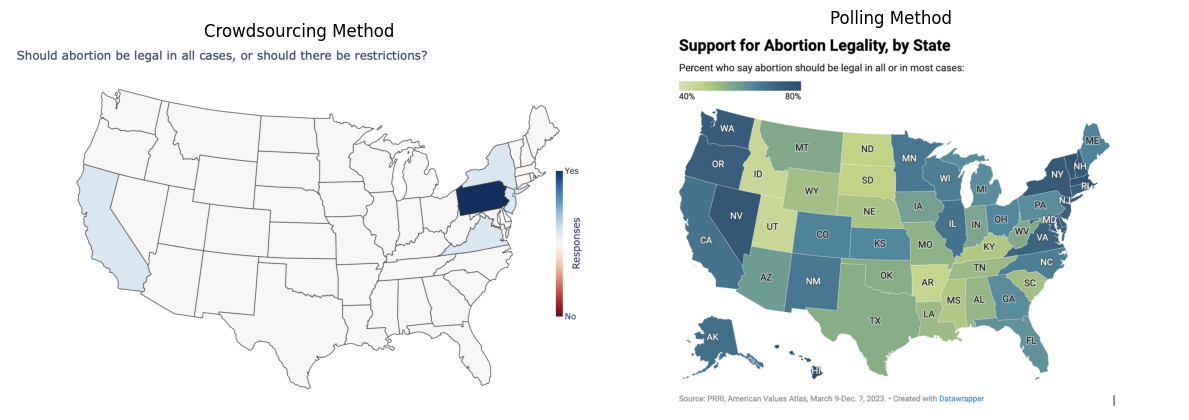

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Assuming the file names are known
image_file_1 = "map1.png"  # Replace with your first image file name
image_file_2 = "map2.png"  # Replace with your second image file name

# Read the images
img1 = Image.open('/content/drive/My Drive/NETS Data/map1.png')
img2 = Image.open('/content/drive/My Drive/NETS Data/map2.png')

img1_resized = img1.resize((img1.width * 2, img1.height * 2))

# Display the images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for desired size
axes[0].imshow(img1)
axes[0].axis('off')  # Hide axes
axes[0].set_title('Crowdsourcing Method')

axes[1].imshow(img2)
axes[1].axis('off')  # Hide axes
axes[1].set_title('Polling Method')

# Adjust spacing between the plots
plt.subplots_adjust(wspace=0.05)  # Decrease space between the images

plt.tight_layout()
plt.show()
